In [60]:
import chess
import chess.pgn
import chess.engine
import random
import time
import numpy as np
from math import log,sqrt,e,inf
from IPython.display import display, HTML, clear_output

engine = chess.engine.SimpleEngine.popen_uci("stockfish")


class node:
    def __init__(self,*board):
        if(len(board)>0):
            self.state = board
        else:
            self.state = chess.Board()
        self.action = ''
        self.children = set()
        self.parent = None
        self.N = 0
        self.n = 0
        self.v = 0

def ucb1(curr_node):
    ans = curr_node.v+2*(sqrt(log(curr_node.N+e+(10**-6))/(curr_node.n+(10**-10))))
    return ans

def rollout(board,curr_node):
    global engine
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    result = engine.play(curr_node.state, chess.engine.Limit(time=0.001))
    move = curr_node.state.san(result.move)
    tmp_state = chess.Board(curr_node.state.fen())
    tmp_state.push_san(move)

    to_use = None
    
    for i in all_moves:
        tmp_state1 = chess.Board(curr_node.state.fen())
        tmp_state1.push_san(i)
        child = node()
        child.state = tmp_state1
        child.parent = curr_node
        curr_node.children.add(child)
        if(child.state==tmp_state):
            to_use = child
            break
            
    return rollout(board,to_use)

def rolloutTree(board,curr_node):
    
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
    rnd_state = random.choice(list(curr_node.children))

    return rolloutTree(board,rnd_state)


def expand(curr_node,white):
    if(len(curr_node.children)==0):
        return curr_node
    max_ucb = -inf
    if(white):
        idx = -1
        max_ucb = -inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp>max_ucb):
                idx = i
                max_ucb = tmp
                sel_child = i

        return(expand(sel_child,0))

    else:
        idx = -1
        min_ucb = inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp<min_ucb):
                idx = i
                min_ucb = tmp
                sel_child = i

        return expand(sel_child,1)

def rollback(curr_node,reward):
    curr_node.n+=1
    curr_node.v+=reward
    while(curr_node.parent!=None):
        curr_node.N+=1
        curr_node = curr_node.parent
    return curr_node

def mcts_pred(board,curr_node,over,white,choice,base1,base2,iterations=10):
    if(over):
        return -1
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    map_state_move = dict()
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
        map_state_move[child] = i
        
    while(iterations>0):
        if(white):
            idx = -1
            max_ucb = -inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp>max_ucb):
                    idx = i
                    max_ucb = tmp
                    sel_child = i
            ex_child = expand(sel_child,0)
            if(base1=="Tree"):
                reward,state = rolloutTree(board,ex_child)
            elif(base1=="AI"):
                reward,state = rollout(board,ex_child)
            curr_node = rollback(state,reward)
            iterations-=1
        elif(choice!=2):
            idx = -1
            min_ucb = inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp<min_ucb):
                    idx = i
                    min_ucb = tmp
                    sel_child = i

            ex_child = expand(sel_child,1)

            if(base2=="Tree"):
                reward,state = rolloutTree(board,ex_child)
            elif(base2=="AI"):
                reward,state = rollout(board,ex_child)

            curr_node = rollback(state,reward)
            iterations-=1

    if(white):
        
        mx = -inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp>mx):
                mx = tmp
                selected_move = map_state_move[i]
        return selected_move
    elif(choice!=2):
        mn = inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp<mn):
                mn = tmp
                selected_move = map_state_move[i]
        return selected_move
    

def staticAnalysis(board, color):
    score = random.random()

    ## Check some things about this move:
    # score += 10 if board.is_capture(move) else 0
    # Now check some other things:
    for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.KING, 0), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 5),
                           (chess.ROOK, 3)]:
        score += len(board.pieces(piece, color)) * value
        score -= len(board.pieces(piece, not color)) * value
        # can also check things about the pieces position here
    # Check global things about the board
    score += 100 if board.is_checkmate() else 0
    return score

#This method is for game that can be customized by the user
def gameWithInput():
    #customizing problem size
    #to randomize the starting position we can customize the board. for now I am using a random board setup
    #board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
    print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
    s = input("p or P or Q or R or q or b . Only write the letter \n")
    b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
    b2 = "8/8/8/8/8/r6"+s+"/1kr5/7K"
    b3 = "8/7"+s+"/7P/8/8/n7/1k6/7K"
    b4 = "8//1kr5/7"+s+"/8/8/r7/7K/8"
    b5 = "8/7k/p1p2p2p/7"+s+"/8/r7/1K1n4/8"
    b6= "8/8/8/8/8/8/7Q/5k1K"
    board = chess.Board(b6)
    score=0

    #to let the pc choose random positions
    #board = chess.Board.from_chess960_pos(random.randint(0, 959))
    #board = chess.Board()
    print(board)
    #display_board(board)
    choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
    base1="AI"
    base2="AI"
    if(choice==2):
        white=int(input("Do you want to play as 0.First player or 1.Second player? write 0 or 1= "))
    else:
        white = 1

    if(choice==3):
        base1 = "Tree"

    elif (choice==5):
        base2="NN"
    elif(choice==4):
        base1="Tree"
        base2 = "Tree"
    moves = 0
    pgn = []
    game = chess.pgn.Game()
    evaluations = []
    sm = 0
    cnt = 0
    curve  = [ [0]*1000 for i in range(2)]
   # curve = np.zeros((5,100,1000,2))

    j=0
    while((not board.is_game_over())):
        all_moves = [board.san(i) for i in list(board.legal_moves)]
        start = time.time()
        if(white==1 or choice!=2):
            root = node(board)
            root.state = board
            result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
            print("time taken to iteration",j,(time.time()-start))
        elif(choice==2):
            print("input format should be something like a2, b6, g3, first one is row, second one is colum")
            print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
            to=input("Write where you want to go = ")
            frm = input("write from where you want to move = ")
            result=frm+to
        try:
            board.push_san(result)

        except:
            print(result)
            print("invalid move. game over")
            break
        #print(result)
        score = staticAnalysis(board,white)
        col="BLACK"
        if(white):
            col="WHITE"
        print("score for ",col,"= ",score)
        if(score<0):
            score*=-1
        curve[white].append(score)
        pgn.append(result)
        white ^= 1
        j+=1

        moves+=1
        #info = engine.analyse(board, chess.engine.Limit(depth=24))
        #evaluat += info['score'].white()
        print(board)

        print("-----------move done-----------")

    print(" ".join(pgn))
    print()
    #{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

    print(info)
    #print(evaluations)
    #We are showing score for each player after each move, so in final result the score is only based on the winner.
    #If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
    print(board.result())

    game.headers["Result"] = board.result()


#This method is for generating 100 games for each problem size
def gameHistogram():
    #customizing problem size
    #to randomize the starting position we can customize the board. for now I am using a random board setup
    #board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
    print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
    s = input("p or P or Q or R or q or b . Only write the letter \n")
    b1 = "8/8/8/8/8/r7/1kr5/7K"
    b2 = "8/8/8/8/8/r7/1kr5/7K"
    b3 = "8/8/7P/8/8/n6K/8/Q1R4K"
    b4 = "7P/8/1kr5/7/8/r7/7K/8"
    b5 = "8/7k/p1p2p2p/8/8/r7/1K1n4/8"
    #    curve  = [ [0]*1000 for i in range(2)]
    #curve for 5 instances and 100 games for each
    curve = [[[[0 for x in range(5)] for x in range(100)] for x in range(2)]for i in range(2)]
    #curve = np.zeros((5,100,2))
    brd = [b1,b2,b3,b4,b5]
    cont=-1
    for b in brd: 
        cont+=1
        board = chess.Board(b)
        score=0
        white = 1
        print(board)
        for loop in range(0,100):
            c=["AI-AI game","AI-AI game","Baseline tree-AI tree", "tree vs tree", "AI-NN game"]
            #display_board(board)
            #choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
            choice = random.randint(1, 5)
            print(c[choice-1])
            base1="AI"
            base2="AI"
            if(choice==2):
                choice =1
            if(choice==3):
                base1 = "Tree"
            elif (choice==5):
                base2="NN"
            elif(choice==4):
                base1="Tree"
                base2 = "Tree"
            moves = 0
            pgn = []
            game = chess.pgn.Game()
            evaluations = []
            sm = 0
            cnt = 0
#            curve  = [ [0]*2 for i in range(2)]

            j=0
            while((not board.is_game_over())):
                all_moves = [board.san(i) for i in list(board.legal_moves)]
                start = time.time()
                if(white==1 or choice!=2):
                    root = node(board)
                    root.state = board
                    result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
                    print("time taken to iteration",j,(time.time()-start))
                elif(choice==2):
                    print("input format should be something like a2, b6, g3, first one is row, second one is colum")
                    print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
                    to=input("Write where you want to go = ")
                    frm = input("write from where you want to move = ")
                    result=frm+to
                try:
                    board.push_san(result)

                except:
                    print(result)
                    print("invalid move. game over")
                    break
                #print(result)
                score = staticAnalysis(board,white)
                col="BLACK"
                if(white):
                    col="WHITE"
                print("score for ",col,"= ",score)
                if(score<0):
                    score*=-1
                #curve[cont][loop][white].append(score)
                pgn.append(result)
                white ^= 1
                j+=1

                moves+=1
                #info = engine.analyse(board, chess.engine.Limit(depth=24))
                #evaluat += info['score'].white()
                print(board)

                print("-----------move done-----------")

            print(" ".join(pgn))
            print()
            #{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

            print(info)
            #print(evaluations)
            #We are showing score for each player after each move, so in final result the score is only based on the winner.
            #If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
            print(board.result())

            game.headers["Result"] = board.result()

            
#start the code for histogram            
gameHistogram()

We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?
p or P or Q or R or q or b . Only write the letter 
R
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . Q
. . . . . k . K
Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?
 write 1 or 2 or 3 or 4 or 5= 3
time taken to iteration 0 0.5216670036315918
score for  WHITE =  10.643790043189824
. . . . . . . .
. . . . . . . .
. . . . . . . Q
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . k . K
-----------move done-----------
time taken to iteration 1 0.4380941390991211
score for  BLACK =  -9.67775640506604
. . . . . . . .
. . . . . . . .
. . . . . . . Q
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . k . . K
-----------move done-----------
time ta

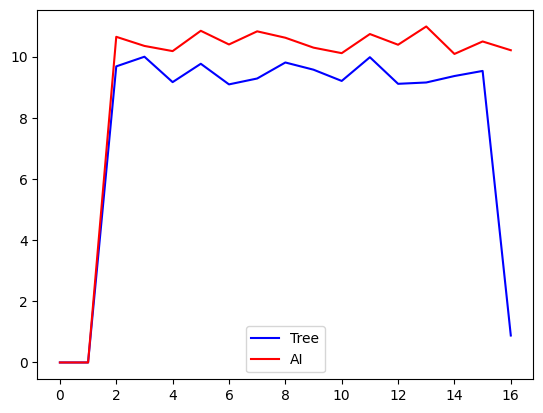

In [62]:

import numpy as np
import matplotlib.pyplot as pt


# visualize learning curves on train/test data
pt.plot(curve[0], 'b-')
pt.plot(curve[1], 'r-')
#pt.plot([0, len(curve[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
pt.legend([base1,base2])
pt.show()

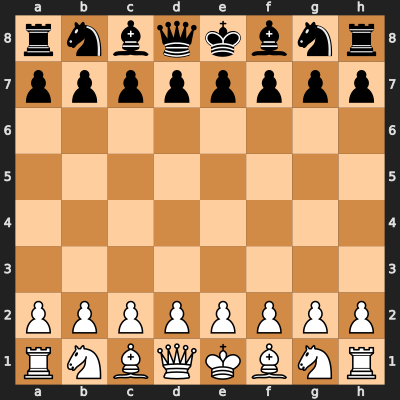

In [42]:
import chess
import chess.svg

from IPython.display import SVG

board = chess.Board()
SVG(chess.svg.board(board=board,size=400))


In [35]:
import numpy as np
c=[[[]*300 for i in range(2)]*100 for i in range(5)]
c[0][0][0].append(12)
c[0][0][0].append(13)
c[0][0][1].append(2)
c[0][0][1].append(13)
print(c[0])

IndexError: list index out of range